In [1]:
import os
import logging
import argparse
import pandas as pd
import numpy as np

import nibabel as nib
from collections import defaultdict
from copy import deepcopy
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
import sklearn.linear_model as lm
import sklearn.svm as svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, roc_auc_score, balanced_accuracy_score

# Dataset

In [2]:
def extract_mask(participant_df, selection, unique_keys=["participant_id", "session", "study"], check_uniqueness=True):
        _source_keys = participant_df[unique_keys].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
        if check_uniqueness:
            assert len(set(_source_keys)) == len(_source_keys), f"Multiple identique identifiers found"
        _target_keys = selection[unique_keys].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
        mask = _source_keys.isin(_target_keys).values.astype(bool)
        return mask

## Loading Data

In [3]:
# Parameters
root = "/neurospin/psy_sbox/analyses/2023_pauriau_EarlyBrainMarkersWithContrastiveAnalysis/data/root"
interim =  "/neurospin/psy_sbox/analyses/2023_pauriau_EarlyBrainMarkersWithContrastiveAnalysis/data/interim"
id_types = {"participant_id": str,
            "session": int,
            "acq": int,
            "run": int}

In [4]:
# Error in the npy file generate by the package make_dataset
"""
try:
    arr = np.load(os.path.join(root, "ausz_t1mri_mwp1_gs-raw_data64.npy"))
except ValueError as e:
    print(e)
    path_to_raw = "/neurospin/psy_sbox/analyses/2023_pauriau_EarlyBrainMarkersWithContrastiveAnalysis/data/raw"
    arr = np.load(os.path.join(path_to_raw, "cat12vbm", "ausz_cat12vbm_mwp1-gs.npy"), allow_pickle=True)
    arr = arr.astype(np.float64)
    np.save(os.path.join(path_to_raw, "cat12vbm", "ausz_cat12vbm_mwp1-gs.npy"), arr)
"""

'\ntry:\n    arr = np.load(os.path.join(root, "ausz_t1mri_mwp1_gs-raw_data64.npy"))\nexcept ValueError as e:\n    print(e)\n    path_to_raw = "/neurospin/psy_sbox/analyses/2023_pauriau_EarlyBrainMarkersWithContrastiveAnalysis/data/raw"\n    arr = np.load(os.path.join(path_to_raw, "cat12vbm", "ausz_cat12vbm_mwp1-gs.npy"), allow_pickle=True)\n    arr = arr.astype(np.float64)\n    np.save(os.path.join(path_to_raw, "cat12vbm", "ausz_cat12vbm_mwp1-gs.npy"), arr)\n'

In [5]:
arr = np.load(os.path.join(interim, "ausz_t1mri_mwp1_gs-raw_data64.npy"), mmap_mode="r")
df = pd.read_csv(os.path.join(root, "ausz_t1mri_participants.csv"), dtype=id_types)
scheme = pd.read_csv(os.path.join(root, "stratified_10_fold_ausz.csv"), dtype=id_types)
assert (df["participant_id"] == scheme["participant_id"]).all(), print("Scheme and df do not have same order")
print(f"Data shape : {arr.shape} | {len(df)} | {len(scheme)}")
try:
    m_vbm = nib.load(os.path.join(root, "mni_cerebrum-gm-mask_1.5mm.nii.gz"))
    brain_mask = (m_vbm.get_fdata() != 0).astype(bool)
    print(f"Brain mask shape : {brain_mask.shape}")
except FileNotFoundError:
    raise FileNotFoundError("Brain masks not found. You can find them in /masks directory "
                            "and mv them to this directory: %s" % root)
label = "NSS"
arr = arr[:, 0, brain_mask]
print(f"Data shape after applying mask: {arr.shape} | {len(df)} | {len(scheme)}")

Data shape : (98, 1, 121, 145, 121) | 98 | 98
Brain mask shape : (121, 145, 121)
Data shape after applying mask: (98, 331695) | 98 | 98


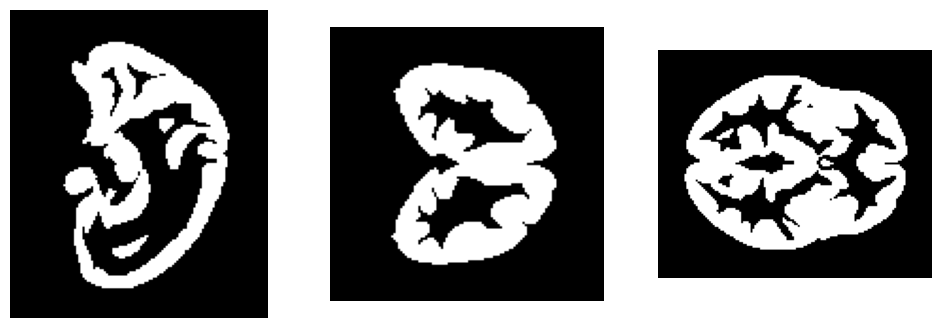

In [10]:
# Show brain mask
coord = (50, 50, 50)

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(brain_mask[coord[0], ...], cmap="gray")
ax[0].set_axis_off()
ax[1].imshow(brain_mask[:, coord[1], :], cmap="gray")
ax[1].set_axis_off()
ax[2].imshow(brain_mask[..., coord[2]], cmap="gray")
ax[2].set_axis_off()
plt.show()

# Regression of NSS scores

## Ridge

In [8]:
nb_folds=10
saving_dir = "/neurospin/psy_sbox/analyses/2023_pauriau_EarlyBrainMarkersWithContrastiveAnalysis/models/vbm/20240704_ridge"
os.makedirs(saving_dir, exist_ok=True)
n_jobs = 10
logs = defaultdict(list)

### Training

In [12]:
# Ridge

for fold in range(nb_folds):
    # 0) Load data
    train_selection = scheme.loc[scheme[f"fold{fold}"] == "train", ["participant_id", "session", "study"]]
    train_mask = extract_mask(df, train_selection)
    #print(train_mask.shape)
    train_data = arr[train_mask]
    y_train = df.loc[train_mask, label].values.astype(np.float32)

    test_selection = scheme.loc[scheme[f"fold{fold}"] == "test", ["participant_id", "session", "study"]]
    test_mask = extract_mask(df, test_selection)
    test_data = arr[test_mask]
    y_test = df.loc[test_mask, label].values.astype(np.float32)
    #print(f"Train data shape : {train_data.shape} | {y_train.shape}")
    #print(f"Test data shape : {test_data.shape} | {y_test.shape}")
    

    # 1) Normalization
    scaler = preprocessing.StandardScaler
    ss = scaler().fit(train_data)
    train_data_ = ss.transform(train_data)
    test_data_ = ss.transform(test_data)

    # 2) Training    
    #model = lm.Ridge(alpha=0.1, fit_intercept=True, solver="auto")
    #model.fit(train_data, y_train)
    hyperparams = {'alpha': [1e-1, 1, 10, 10**2, 10**3], 
                    'fit_intercept': [True],
                    'solver': ['auto', 'svd', 'cholesky', 'sag']}
    model_cv = GridSearchCV(lm.Ridge(), hyperparams, refit=True, n_jobs=n_jobs, scoring="neg_mean_absolute_error", cv=3)
    model_cv.fit(train_data, y_train)
    best_score, best_params = model_cv.best_score_, model_cv.best_params_
    print(f"Model train - best score : {best_score:.2g} | best params : {best_params}")

    # 3) Testing
    #y_pred_test = model.predict(test_data)
    #r2 = model.score(test_data, y_test)
    y_pred_test = model_cv.predict(test_data)
    r2 = model_cv.best_estimator_.score(test_data, y_test)
    rmse = mean_squared_error(y_pred=y_pred_test, y_true=y_test, squared=False) 
    mae = mean_absolute_error(y_pred=y_pred_test, y_true=y_test)

    # 4) Saving
    for metric, value in zip(["r2", "rmse", "mae"], [r2, rmse, mae]):
        logs["fold"].append(fold)
        logs["alpha"].append(best_params["alpha"])
        logs["split"].append("test")
        logs["metric"].append(metric)
        logs["value"].append(value)
    np.save(os.path.join(saving_dir, f"nss_pred_test_fold-{fold}.npy"), y_pred_test)

Model train - best score : -6.1 | best params : {'alpha': 0.1, 'fit_intercept': True, 'solver': 'auto'}
Model train - best score : -5.9 | best params : {'alpha': 1000, 'fit_intercept': True, 'solver': 'auto'}
Model train - best score : -5.4 | best params : {'alpha': 0.1, 'fit_intercept': True, 'solver': 'sag'}
Model train - best score : -6 | best params : {'alpha': 0.1, 'fit_intercept': True, 'solver': 'sag'}
Model train - best score : -6.2 | best params : {'alpha': 0.1, 'fit_intercept': True, 'solver': 'sag'}
Model train - best score : -5.7 | best params : {'alpha': 0.1, 'fit_intercept': True, 'solver': 'auto'}
Model train - best score : -6.3 | best params : {'alpha': 100, 'fit_intercept': True, 'solver': 'sag'}
Model train - best score : -5.9 | best params : {'alpha': 1000, 'fit_intercept': True, 'solver': 'svd'}
Model train - best score : -5.8 | best params : {'alpha': 0.1, 'fit_intercept': True, 'solver': 'sag'}
Model train - best score : -6 | best params : {'alpha': 1000, 'fit_int

In [ ]:
# Saving
logs_df = pd.DataFrame(logs)
logs_df.to_csv(os.path.join(saving_dir, "results_predictions_nss.csv"), sep=",", index=False)

### Testing

In [9]:
results = pd.read_csv(os.path.join(saving_dir, "results_predictions_nss.csv"), sep=",")

In [10]:
results[["metric", "value"]].groupby("metric").describe()

value                                                              \
       count      mean       std       min       25%       50%       75%   
metric                                                                     
mae     10.0  6.003110  1.546883  3.379492  4.981721  6.243459  6.800347   
r2      10.0 -0.314436  0.506534 -1.587338 -0.371316 -0.174267 -0.031654   
rmse    10.0  7.398831  2.217516  4.600213  5.967967  7.322245  8.349307   

                   
              max  
metric             
mae      8.850287  
r2       0.127901  
rmse    12.252311

In [12]:
df_pred = df[["participant_id", "age", "sex", "diagnosis", "NSS"]].copy(deep=True)
for fold in range(nb_folds):
    df_pred.loc[scheme[f"fold{fold}"] == "test", "y_pred"] = np.load(os.path.join(saving_dir, f"nss_pred_test_fold-{fold}.npy"))

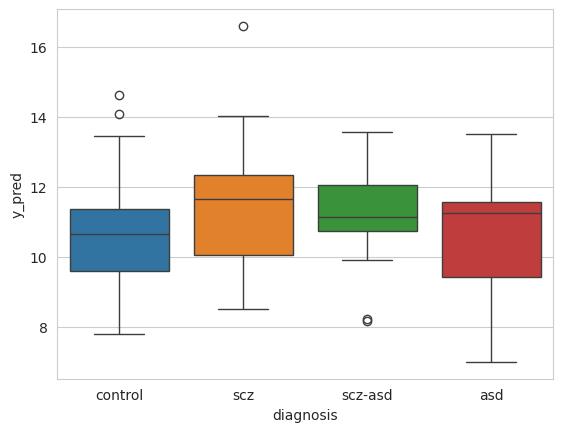

In [13]:
with sns.axes_style("whitegrid"):
    sns.boxplot(data=df_pred, x="diagnosis", y="y_pred", order=("control", "scz", "scz-asd", "asd"), hue="diagnosis", hue_order=("control", "scz", "scz-asd", "asd"))
plt.show()

In [16]:
data = defaultdict(list)
for diag in ("control", "scz", "scz-asd", "asd"):
    
    r2 = r2_score(y_pred=df_pred.loc[df_pred['diagnosis'] == diag, 'y_pred'],
                           y_true=df_pred.loc[df_pred['diagnosis'] == diag, 'NSS'])
    mae = mean_absolute_error(y_pred=df_pred.loc[df_pred['diagnosis'] == diag, 'y_pred'],
                                       y_true=df_pred.loc[df_pred['diagnosis'] == diag, 'NSS'])
    rmse = mean_squared_error(y_pred=df_pred.loc[df_pred['diagnosis'] == diag, 'y_pred'],
                                       y_true=df_pred.loc[df_pred['diagnosis'] == diag, 'NSS'],
                                       squared=False)
    print(f"# {diag}")
    print(f"R2:", r2)
    print(f"MAE:", mae)
    print(f"RMSE:", rmse)

    data["diagnosis"].append(diag)
    data["r2"].append(r2)
    data["mean_absolute_error"].append(mae)
    data["root_mean_squared_error"].append(rmse)
data_df = pd.DataFrame(data)

# control
R2: -2.232959476310087
MAE: 5.957525765454328
RMSE: 7.091578155996122
# scz
R2: -0.1825645840350978
MAE: 5.53385697878324
RMSE: 6.399954600730917
# scz-asd
R2: 0.003382042552847131
MAE: 5.514926433563232
RMSE: 8.297221038128109
# asd
R2: -1.0731071804403425
MAE: 6.9215170097351075
RMSE: 8.821816340965757


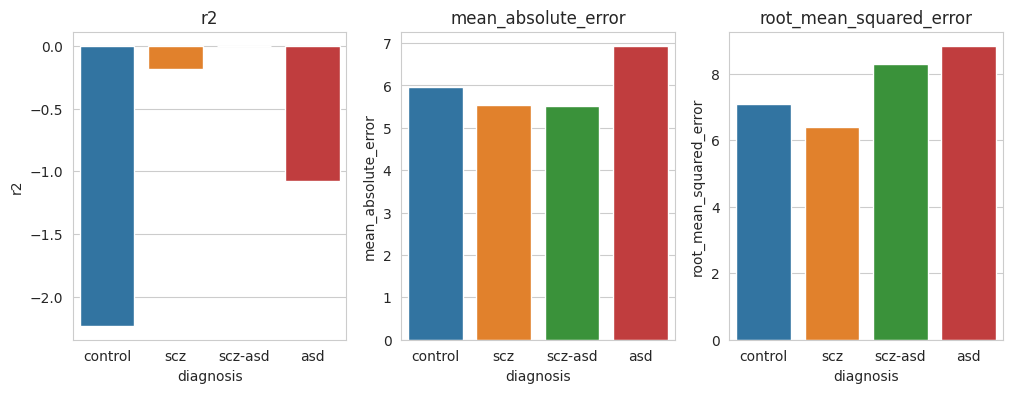

In [20]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(1, 3, figsize=(4*3, 4))
    for i, metric in enumerate(["r2", "mean_absolute_error", "root_mean_squared_error"]):
        sns.barplot(data=data_df, x="diagnosis", y=metric, order=("control", "scz", "scz-asd", "asd"), hue="diagnosis", hue_order=("control", "scz", "scz-asd", "asd"), ax=ax[i])
        ax[i].set_title(metric)
plt.show()

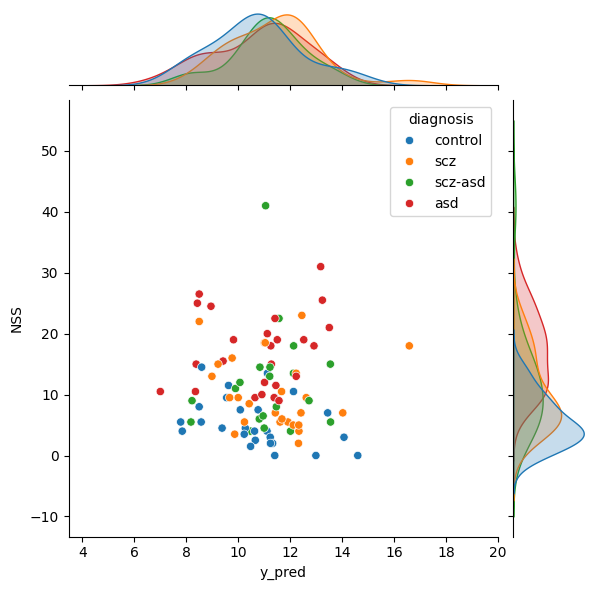

In [20]:
sns.jointplot(data=df_pred, x="y_pred", y="NSS", hue="diagnosis", hue_order=("control", "scz", "scz-asd", "asd"))
plt.show()

## All models

In [3]:
saving_dir = "/neurospin/psy_sbox/analyses/2023_pauriau_EarlyBrainMarkersWithContrastiveAnalysis/models/vbm/20240723_all_models"
nb_folds = 10
cv_train = 3
logs = defaultdict(list)

In [16]:
# All models
models = dict(
    lrl2_cv=make_pipeline(
        preprocessing.StandardScaler(),
        # preprocessing.MinMaxScaler(),
        GridSearchCV(lm.Ridge(),
                     param_grid={'alpha': 10. ** np.arange(-1, 3)},
                     cv=cv_train, n_jobs=cv_train)),

    lrenet_cv=make_pipeline(
        preprocessing.StandardScaler(),
        # preprocessing.MinMaxScaler(),
        GridSearchCV(lm.ElasticNet(max_iter=1000),
                     param_grid={'alpha': 10. ** np.arange(-1, 2),
                                 'l1_ratio': [.1, .5]},
                     cv=cv_train, n_jobs=cv_train)),

    svmrbf_cv=make_pipeline(
        # preprocessing.StandardScaler(),
        preprocessing.MinMaxScaler(),
        GridSearchCV(svm.SVR(),
                     # {'kernel': ['poly', 'rbf'], 'C': 10. ** np.arange(-3, 3)},
                     param_grid={'kernel': ['poly', 'rbf'],
                                 'C': 10. ** np.arange(-1, 2)},
                     cv=cv_train, n_jobs=cv_train)),)

"""    forest_cv=make_pipeline(
        # preprocessing.StandardScaler(),
        preprocessing.MinMaxScaler(),
        GridSearchCV(RandomForestRegressor(random_state=1),
                     param_grid={"n_estimators": [100]},
                     cv=cv_train, n_jobs=cv_train)),

    gb_cv=make_pipeline(
        preprocessing.MinMaxScaler(),
        GridSearchCV(estimator=GradientBoostingRegressor(random_state=1),
                     param_grid={"n_estimators": [100],
                                 "subsample":[1, .5],
                                 "learning_rate": [.1, .5]
                                 },
                     cv=cv_train, n_jobs=cv_train)))"""

'    forest_cv=make_pipeline(\n        # preprocessing.StandardScaler(),\n        preprocessing.MinMaxScaler(),\n        GridSearchCV(RandomForestRegressor(random_state=1),\n                     param_grid={"n_estimators": [100]},\n                     cv=cv_train, n_jobs=cv_train)),\n\n    gb_cv=make_pipeline(\n        preprocessing.MinMaxScaler(),\n        GridSearchCV(estimator=GradientBoostingRegressor(random_state=1),\n                     param_grid={"n_estimators": [100],\n                                 "subsample":[1, .5],\n                                 "learning_rate": [.1, .5]\n                                 },\n                     cv=cv_train, n_jobs=cv_train)))'

In [17]:
for fold in range(nb_folds):
    print(f"\nFold: {fold}")

    # 0) Load data
    train_selection = scheme.loc[scheme[f"fold{fold}"] == "train", ["participant_id", "session", "study"]]
    train_mask = extract_mask(df, train_selection)
    train_data = arr[train_mask]
    y_train = df.loc[train_mask, label].values.astype(np.float32)

    test_selection = scheme.loc[scheme[f"fold{fold}"] == "test", ["participant_id", "session", "study"]]
    test_mask = extract_mask(df, test_selection)
    test_data = arr[test_mask]
    y_test = df.loc[test_mask, label].values.astype(np.float32)

    # 2) Training    
    for model_name, model_cv in models.items():
        name = model_name.split("_")[0]
        os.makedirs(os.path.join(saving_dir, name), exist_ok=True)
        model_cv.fit(train_data, y_train)
        best_score, best_params = model_cv[1].best_score_, model_cv[1].best_params_
        print(f"Model {name} train - best score : {best_score:.2g} | best params : {best_params}")

        # 3) Testing
        y_pred_test = model_cv.predict(test_data)
        r2 = r2_score(y_pred=y_pred_test, y_true=y_test)
        rmse = mean_squared_error(y_pred=y_pred_test, y_true=y_test, squared=False) 
        mae = mean_absolute_error(y_pred=y_pred_test, y_true=y_test)

        # 4) Saving
        for metric, value in zip(["r2", "rmse", "mae"], [r2, rmse, mae]):
            logs["fold"].append(fold)
            logs["model"].append(name)
            logs["split"].append("test")
            logs["metric"].append(metric)
            logs["value"].append(value)
        np.save(os.path.join(saving_dir, name, f"nss_pred_test_fold-{fold}.npy"), y_pred_test)

# 5) Saving logs
logs_df = pd.DataFrame(logs)
logs_df.to_csv(os.path.join(saving_dir, "results_predictions_nss.csv"), sep=",", index=False)


Fold: 0


/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:237: LinAlgWarning: Ill-conditioned matrix (rcond=4.82034e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:237: LinAlgWarning: Ill-conditioned matrix (rcond=5.23819e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:237: LinAlgWarning: Ill-conditioned matrix (rcond=3.54278e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


Model lrl2 train - best score : -0.065 | best params : {'alpha': 0.1}


/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.308e+00, tolerance: 2.798e-01
  model = cd_fast.enet_coordinate_descent(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.617e+00, tolerance: 3.578e-01
  model = cd_fast.enet_coordinate_descent(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider incre

Model lrenet train - best score : -0.085 | best params : {'alpha': 10.0, 'l1_ratio': 0.1}
Model svmrbf train - best score : -0.064 | best params : {'C': 10.0, 'kernel': 'rbf'}

Fold: 1


/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:237: LinAlgWarning: Ill-conditioned matrix (rcond=4.30036e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:237: LinAlgWarning: Ill-conditioned matrix (rcond=4.22539e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


Model lrl2 train - best score : -0.043 | best params : {'alpha': 100.0}


/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.837e+00, tolerance: 2.537e-01
  model = cd_fast.enet_coordinate_descent(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.564e+00, tolerance: 3.501e-01
  model = cd_fast.enet_coordinate_descent(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider incre

Model lrenet train - best score : -0.01 | best params : {'alpha': 1.0, 'l1_ratio': 0.5}
Model svmrbf train - best score : -0.019 | best params : {'C': 10.0, 'kernel': 'rbf'}

Fold: 2


/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:237: LinAlgWarning: Ill-conditioned matrix (rcond=5.86774e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:237: LinAlgWarning: Ill-conditioned matrix (rcond=4.9023e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:237: LinAlgWarning: Ill-conditioned matrix (rcond=3.89809e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


Model lrl2 train - best score : 0.028 | best params : {'alpha': 0.1}


/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.173e+00, tolerance: 2.745e-01
  model = cd_fast.enet_coordinate_descent(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.141e+00, tolerance: 2.689e-01
  model = cd_fast.enet_coordinate_descent(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider incre

Model lrenet train - best score : -0.022 | best params : {'alpha': 10.0, 'l1_ratio': 0.5}
Model svmrbf train - best score : 0.024 | best params : {'C': 1.0, 'kernel': 'poly'}

Fold: 3


/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:237: LinAlgWarning: Ill-conditioned matrix (rcond=5.63491e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:237: LinAlgWarning: Ill-conditioned matrix (rcond=2.96913e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:237: LinAlgWarning: Ill-conditioned matrix (rcond=5.48143e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


Model lrl2 train - best score : -0.07 | best params : {'alpha': 100.0}


/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.061e+00, tolerance: 3.634e-01
  model = cd_fast.enet_coordinate_descent(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.062e+00, tolerance: 2.618e-01
  model = cd_fast.enet_coordinate_descent(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider incre

Model lrenet train - best score : -0.083 | best params : {'alpha': 10.0, 'l1_ratio': 0.1}
Model svmrbf train - best score : -0.047 | best params : {'C': 10.0, 'kernel': 'rbf'}

Fold: 4


/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:237: LinAlgWarning: Ill-conditioned matrix (rcond=5.68164e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:237: LinAlgWarning: Ill-conditioned matrix (rcond=5.39822e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


Model lrl2 train - best score : -0.085 | best params : {'alpha': 100.0}


/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.366e+00, tolerance: 2.758e-01
  model = cd_fast.enet_coordinate_descent(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.908e+00, tolerance: 3.868e-01
  model = cd_fast.enet_coordinate_descent(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider incre

Model lrenet train - best score : -0.11 | best params : {'alpha': 0.1, 'l1_ratio': 0.1}
Model svmrbf train - best score : -0.067 | best params : {'C': 10.0, 'kernel': 'rbf'}

Fold: 5


/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:237: LinAlgWarning: Ill-conditioned matrix (rcond=5.33232e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:237: LinAlgWarning: Ill-conditioned matrix (rcond=4.91999e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:237: LinAlgWarning: Ill-conditioned matrix (rcond=3.13833e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:237: LinAlgWarning: Ill-conditioned matrix (rcond=2.3211e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=

Model lrl2 train - best score : -0.04 | best params : {'alpha': 0.1}


/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.110e+00, tolerance: 2.375e-01
  model = cd_fast.enet_coordinate_descent(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.791e+00, tolerance: 3.409e-01
  model = cd_fast.enet_coordinate_descent(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider incre

Model lrenet train - best score : -0.034 | best params : {'alpha': 10.0, 'l1_ratio': 0.1}
Model svmrbf train - best score : -0.048 | best params : {'C': 10.0, 'kernel': 'rbf'}

Fold: 6


/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:237: LinAlgWarning: Ill-conditioned matrix (rcond=4.90988e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:237: LinAlgWarning: Ill-conditioned matrix (rcond=2.01197e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


Model lrl2 train - best score : -0.11 | best params : {'alpha': 100.0}


/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.854e+00, tolerance: 3.650e-01
  model = cd_fast.enet_coordinate_descent(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.878e+00, tolerance: 3.906e-01
  model = cd_fast.enet_coordinate_descent(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider incre

Model lrenet train - best score : -0.11 | best params : {'alpha': 0.1, 'l1_ratio': 0.1}
Model svmrbf train - best score : -0.081 | best params : {'C': 10.0, 'kernel': 'rbf'}

Fold: 7
Model lrl2 train - best score : -0.069 | best params : {'alpha': 100.0}


/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.106e+00, tolerance: 2.607e-01
  model = cd_fast.enet_coordinate_descent(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.912e+00, tolerance: 3.499e-01
  model = cd_fast.enet_coordinate_descent(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider incre

Model lrenet train - best score : -0.032 | best params : {'alpha': 10.0, 'l1_ratio': 0.1}
Model svmrbf train - best score : -0.044 | best params : {'C': 10.0, 'kernel': 'rbf'}

Fold: 8


/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:237: LinAlgWarning: Ill-conditioned matrix (rcond=5.67381e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:237: LinAlgWarning: Ill-conditioned matrix (rcond=5.73781e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:237: LinAlgWarning: Ill-conditioned matrix (rcond=5.42508e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:237: LinAlgWarning: Ill-conditioned matrix (rcond=3.10371e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a

Model lrl2 train - best score : -0.092 | best params : {'alpha': 0.1}


/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.521e+00, tolerance: 3.438e-01
  model = cd_fast.enet_coordinate_descent(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.048e+00, tolerance: 2.460e-01
  model = cd_fast.enet_coordinate_descent(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider incre

Model lrenet train - best score : -0.094 | best params : {'alpha': 0.1, 'l1_ratio': 0.5}
Model svmrbf train - best score : -0.085 | best params : {'C': 10.0, 'kernel': 'rbf'}

Fold: 9


/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:237: LinAlgWarning: Ill-conditioned matrix (rcond=4.02724e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:237: LinAlgWarning: Ill-conditioned matrix (rcond=3.9543e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:237: LinAlgWarning: Ill-conditioned matrix (rcond=5.6173e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


Model lrl2 train - best score : -0.058 | best params : {'alpha': 100.0}


/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.074e+00, tolerance: 2.717e-01
  model = cd_fast.enet_coordinate_descent(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.850e+00, tolerance: 3.769e-01
  model = cd_fast.enet_coordinate_descent(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider incre

Model lrenet train - best score : -0.054 | best params : {'alpha': 10.0, 'l1_ratio': 0.1}
Model svmrbf train - best score : -0.035 | best params : {'C': 10.0, 'kernel': 'rbf'}


Display Results

In [4]:
results = pd.read_csv(os.path.join(saving_dir, "all_models_nss_predictions.csv"))

In [5]:
results.head()

,fold,set,metric,value,model
0,0,train,r2,1.000000,lrl2
1,0,train,rmse,0.000005,lrl2
2,0,train,mae,0.000003,lrl2
3,0,test,r2,-0.672732,lrl2
4,0,test,rmse,5.956396,lrl2


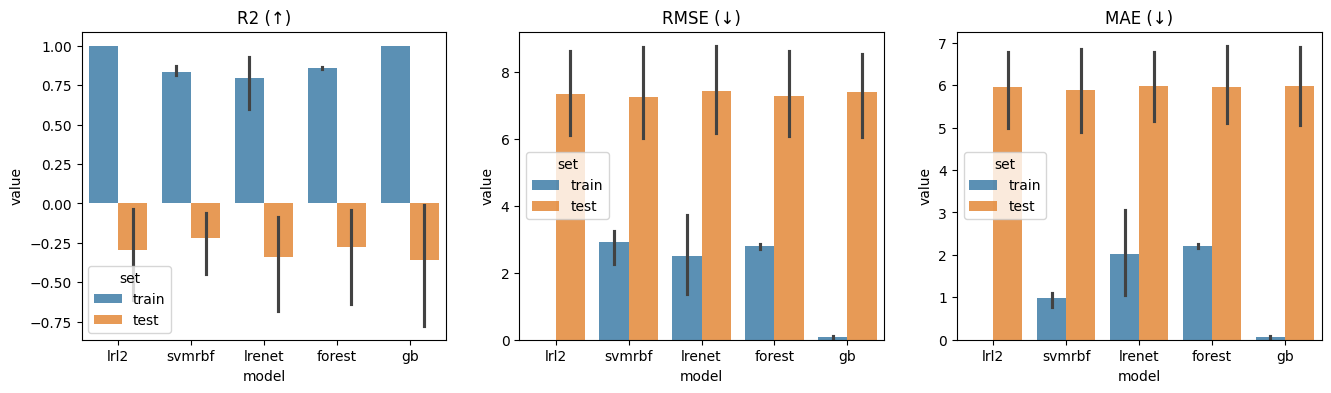

In [18]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
for i, metric in enumerate(["r2", "rmse", "mae"]):
    # data = results[(results["set"] == "test") & (results["metric"] == metric)]
    data = results[results["metric"] == metric]
    sns.barplot(data=data, x="model", y="value", hue="set", ax=ax[i], alpha=0.8)
    title = metric.upper()
    if metric == "r2":
        arrow = "\u2191"
    else:
        arrow = "\u2193"
    title += f" ({arrow})"
    ax[i].set_title(title)
plt.show()

In [21]:
results[results["metric"] == metric].groupby(["model", "set"]).describe()

fold                                          value            \
             count mean      std  min   25%  50%   75%  max count      mean   
model  set                                                                    
forest test   10.0  4.5  3.02765  0.0  2.25  4.5  6.75  9.0  10.0  5.967450   
       train  10.0  4.5  3.02765  0.0  2.25  4.5  6.75  9.0  10.0  2.212513   
gb     test   10.0  4.5  3.02765  0.0  2.25  4.5  6.75  9.0  10.0  5.973822   
       train  10.0  4.5  3.02765  0.0  2.25  4.5  6.75  9.0  10.0  0.061898   
lrenet test   10.0  4.5  3.02765  0.0  2.25  4.5  6.75  9.0  10.0  5.989165   
       train  10.0  4.5  3.02765  0.0  2.25  4.5  6.75  9.0  10.0  2.023778   
lrl2   test   10.0  4.5  3.02765  0.0  2.25  4.5  6.75  9.0  10.0  5.955395   
       train  10.0  4.5  3.02765  0.0  2.25  4.5  6.75  9.0  10.0  0.001147   
svmrbf test   10.0  4.5  3.02765  0.0  2.25  4.5  6.75  9.0  10.0  5.892813   
       train  10.0  4.5  3.02765  0.0  2.25  4.5  6.75  9.0  10.0  0.972638   

                                                                              
                   std           min       25%       50%       75%       max  
model  set                                                                    
forest test   1.558190  3.638500e+00  5.093000  5.997500  7.011000  8.639444  
       train  0.085824  2.032416e+00  2.170994  2.214716  2.280653  2.310787  
gb     test   1.588444  3.409616e+00  5.489935  6.132602  7.158175  8.085405  
       train  0.033293  1.038493e-08  0.064542  0.070934  0.081586  0.090810  
lrenet test   1.409742  4.154798e+00  4.680110  6.246371  6.916119  8.421349  
       train  1.738233  2.705592e-02  0.384041  2.621375  2.673600  5.611034  
lrl2   test   1.510345  3.404829e+00  5.054241  6.188124  6.699066  8.861260  
       train  0.000985  2.730976e-06  0.000003  0.001875  0.001899  0.001958  
svmrbf test   1.619685  3.494146e+00  4.631855  5.912643  6.974489  8.774356  
       train  0.310861  9.996632e-02  1.013456  1.069550  1.105380  1.142018

# Classification

## Classification with a NSS threshold 

In [17]:
path_to_models = "/neurospin/psy_sbox/analyses/2023_pauriau_EarlyBrainMarkersWithContrastiveAnalysis/models"
saving_dir = os.path.join(path_to_models, "vbm", "20240724_classification_logisticregression")
os.makedirs(saving_dir, exist_ok=True)
threshold = 10
n_jobs = 3
nb_folds=10

### Training

In [19]:
# Logistic Regression
logs = defaultdict(list)
for fold in range(nb_folds):
    print(f"\nFold: {fold}")
    # 0) Load data
    train_mask = scheme[f"fold{fold}"] == "train"
    train_data = arr[train_mask]
    y_train = df.loc[train_mask, label].values
    y_train = (y_train > threshold).astype(int)

    test_mask = scheme[f"fold{fold}"] == "test"
    test_data = arr[test_mask]
    y_test = df.loc[test_mask, label].values
    y_test = (y_test > threshold).astype(int)
    # print(f"Train data shape : {train_data.shape} | {y_train.shape} | {np.unique(y_train)}")
    # print(f"Test data shape : {test_data.shape} | {y_test.shape} | {np.unique(y_test)}")
    
    # 1) Normalization
    scaler = preprocessing.StandardScaler
    ss = scaler().fit(train_data)
    train_data_ = ss.transform(train_data)
    test_data_ = ss.transform(test_data)

    # 2) Training 
    model = lm.LogisticRegression(C=1.0, max_iter=10000, solver="sag", penalty="l2", fit_intercept=True, class_weight="balanced")
    model.fit(train_data, y_train)
    print(f"Model train - score on train set: {model.score(train_data, y_train):.2g}")
    # hyperparameters =  {'C': 10. ** np.arange(-1, 3)}
    # model_cv = GridSearchCV(lm.LogisticRegression(max_iter=1000, solver="sag", penalty="l2", fit_intercept=True, class_weight="balanced"), 
    #                         hyperparameters, refit=True, n_jobs=n_jobs, scoring="balanced_accuracy", cv=3)
    # model_cv.fit(train_data, y_train)
    # best_score, best_params = model_cv.best_score_, model_cv.best_params_
    # print(f"Model train - best score : {best_score:.2g} | best params : {best_params}")

    # 3) Testing
    y_pred_test = model.predict(test_data)
    y_score_test = model.predict_proba(test_data)
    # y_pred_test = model_cv.predict(test_data)
    # y_score_test = model_cv.predict_proba(test_data)
    roc_auc = roc_auc_score(y_score=y_score_test[:, 1], y_true=y_test) 
    bacc = balanced_accuracy_score(y_pred=y_pred_test, y_true=y_test)

    # 4) Saving
    for metric, value in zip(["roc_auc", "bacc"], [roc_auc, bacc]):
        logs["fold"].append(fold)
        # logs["C"].append(best_params["C"])
        logs["split"].append("test")
        logs["metric"].append(metric)
        logs["value"].append(value)

# Saving
logs_df = pd.DataFrame(logs)
logs_df.to_csv(os.path.join(saving_dir, f"results_classification_nss_threshold-{threshold}.csv"), sep=",", index=False)


Fold: 0


/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Model train - score on train set: 1

Fold: 1


/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Model train - score on train set: 1

Fold: 2


/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Model train - score on train set: 1

Fold: 3


/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Model train - score on train set: 1

Fold: 4


/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Model train - score on train set: 1

Fold: 5


/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Model train - score on train set: 1

Fold: 6


/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Model train - score on train set: 1

Fold: 7


/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Model train - score on train set: 1

Fold: 8


/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Model train - score on train set: 1

Fold: 9
Model train - score on train set: 1


/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


### Testing

In [20]:
results = pd.read_csv(os.path.join(saving_dir,  f"results_classification_nss_threshold-{threshold}.csv"), sep=",")

In [21]:
results[["metric", "value"]].groupby("metric").describe()

value                                                           \
        count      mean       std    min       25%       50%       75%   
metric                                                                   
bacc     10.0  0.530119  0.124334  0.325  0.453869  0.520833  0.650000   
roc_auc  10.0  0.494532  0.280394  0.150  0.275238  0.437500  0.661667   

                   
              max  
metric             
bacc     0.690476  
roc_auc  1.000000

## Classification of control/patients

In [8]:
path_to_models = "/neurospin/psy_sbox/analyses/2023_pauriau_EarlyBrainMarkersWithContrastiveAnalysis/models"
saving_dir = os.path.join(path_to_models, "vbm", "20240902_classification_logisticregression")
os.makedirs(saving_dir, exist_ok=True)
n_jobs = 3
nb_folds=10
mapping = {"control": 0,
           "asd": 1,
           "scz": 1,
           "scz-asd": 1}

In [9]:
# Logistic Regression
logs = defaultdict(list)
for fold in range(nb_folds):
    print(f"\nFold: {fold}")
    # 0) Load data
    train_mask = scheme[f"fold{fold}"] == "train"
    train_data = arr[train_mask]
    y_train = df.loc[train_mask, "diagnosis"].replace(mapping).values

    test_mask = scheme[f"fold{fold}"] == "test"
    test_data = arr[test_mask]
    y_test = df.loc[test_mask, "diagnosis"].replace(mapping).values
    # print(f"Train data shape : {train_data.shape} | {y_train.shape} | {np.unique(y_train)}")
    # print(f"Test data shape : {test_data.shape} | {y_test.shape} | {np.unique(y_test)}")
        
    # 1) Normalization
    scaler = preprocessing.StandardScaler
    ss = scaler().fit(train_data)
    train_data_ = ss.transform(train_data)
    test_data_ = ss.transform(test_data)

    # 2) Training 
    model = lm.LogisticRegression(C=1.0, max_iter=1000, solver="sag", penalty="l2", fit_intercept=True, class_weight="balanced")
    model.fit(train_data, y_train)
    print(f"Model train - score on train set: {model.score(train_data, y_train):.2g}")
    # hyperparameters =  {'C': 10. ** np.arange(-1, 3)}
    # model_cv = GridSearchCV(lm.LogisticRegression(max_iter=1000, solver="sag", penalty="l2", fit_intercept=True, class_weight="balanced"), 
    #                         hyperparameters, refit=True, n_jobs=n_jobs, scoring="balanced_accuracy", cv=3)
    # model_cv.fit(train_data, y_train)
    # best_score, best_params = model_cv.best_score_, model_cv.best_params_
    # print(f"Model train - best score : {best_score:.2g} | best params : {best_params}")

    # 3) Testing
    y_pred_test = model.predict(test_data)
    y_score_test = model.predict_proba(test_data)
    # y_pred_test = model_cv.predict(test_data)
    # y_score_test = model_cv.predict_proba(test_data)
    roc_auc = roc_auc_score(y_score=y_score_test[:, 1], y_true=y_test) 
    bacc = balanced_accuracy_score(y_pred=y_pred_test, y_true=y_test)

    # 4) Saving
    for metric, value in zip(["roc_auc", "bacc"], [roc_auc, bacc]):
        logs["fold"].append(fold)
        # logs["C"].append(best_params["C"])
        logs["split"].append("test")
        logs["metric"].append(metric)
        logs["value"].append(value)

# Saving
logs_df = pd.DataFrame(logs)
logs_df.to_csv(os.path.join(saving_dir, f"results_classification_diagnosis.csv"), sep=",", index=False)


Fold: 0


/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Model train - score on train set: 1

Fold: 1


/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Model train - score on train set: 1

Fold: 2


/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Model train - score on train set: 1

Fold: 3


/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Model train - score on train set: 1

Fold: 4


/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Model train - score on train set: 1

Fold: 5


/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Model train - score on train set: 1

Fold: 6


/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Model train - score on train set: 1

Fold: 7


/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Model train - score on train set: 1

Fold: 8


/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Model train - score on train set: 1

Fold: 9
Model train - score on train set: 1


/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


### Testing

In [10]:
results = pd.read_csv(os.path.join(saving_dir,  f"results_classification_diagnosis.csv"), sep=",")

In [11]:
results[["metric", "value"]].groupby("metric").describe()

value                                                           
        count      mean       std  min       25%      50%       75%  max
metric                                                                  
bacc     10.0  0.591667  0.168737  0.5  0.500000  0.50000  0.625000  1.0
roc_auc  10.0  0.729167  0.181089  0.5  0.572917  0.71875  0.864583  1.0

In [12]:
roc_auc_score(y_true=df["diagnosis"].replace(mapping).values, y_score=df["NSS"].values)

0.8299426186750131

In [17]:
r2_score(y_true=df.loc[test_mask, "NSS"].values, y_pred=y_score_test[:, 1])

-1.762049824151962

In [18]:
mean_absolute_error(y_true=df.loc[test_mask, "NSS"].values, y_pred=y_score_test[:, 1])

5.58331989645958

In [22]:
roc_auc_score(y_true=(df.loc[test_mask, "NSS"].values > 10).astype(int), y_score=y_score_test[:, 1])

0.8888888888888888

# Predictions of other metadata

In [3]:
path_to_models = "/neurospin/psy_sbox/analyses/2023_pauriau_EarlyBrainMarkersWithContrastiveAnalysis/models"
saving_dir = os.path.join(path_to_models, "vbm", "20240905_all_predictions")
os.makedirs(saving_dir, exist_ok=True)
nb_folds=10
mapping = {"control": 0,
           "asd": 1,
           "scz": 1,
           "scz-asd": 1}

In [4]:
predictions_df = pd.read_csv(os.path.join(saving_dir, "vbm_all_predictions.csv"))

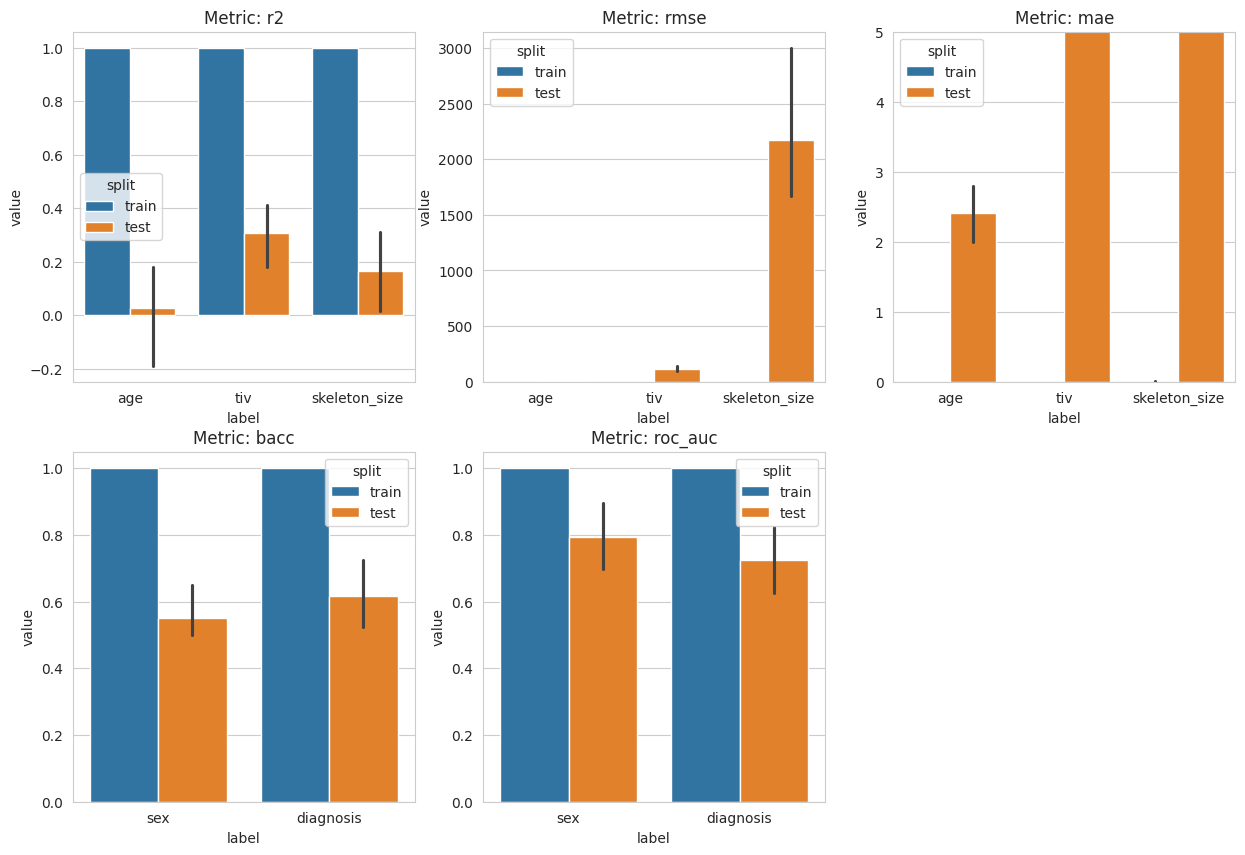

In [6]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(2, 3, figsize=(5*3, 5*2))
    
    for i, metric in enumerate(["r2", "rmse", "mae"]):
        sns.barplot(data=predictions_df[(predictions_df["metric"] == metric) & (predictions_df["fold"] != 6)], x="label", y="value", hue="split", ax=ax[0, i])
        ax[0, i].set_title(f"Metric: {metric}")
    ax[0, 2].set(ylim=(0, 5))

    for i, metric in enumerate(["bacc", "roc_auc"]):
        sns.barplot(data=predictions_df[(predictions_df["metric"] == metric)], x="label", y="value", hue="split", ax=ax[1, i])
        ax[1, i].set_title(f"Metric: {metric}")
    ax[1, 2].set_axis_off()

    plt.show()

**Conclusion**
* age : predictions surprising low
* tiv : predictions all right (better than with skeletons)
* skeleton size : little bit less good than skeletons
* sex, age : good predictions (better than with skeletons)

# Predictions with random permutations

In [2]:
saving_dir = "/neurospin/psy_sbox/analyses/2023_pauriau_EarlyBrainMarkersWithContrastiveAnalysis/models/vbm/20240924_nss_predictions_random_permutations"
n_permutations = 1000

In [32]:
import re

for csv in os.listdir(saving_dir):
    permutation = re.search("permutation-([0-9]+)", csv)
    print(permutation[0])
    print(csv)
    new_name = f"preproc-vbm_model-lrl2_label-{permutation[0]}.csv"
    print(new_name)
    os.replace(os.path.join(saving_dir, csv), os.path.join(saving_dir, new_name))


permutation-286
preproc-vbm_model-lrl2label-permutation-286.csv
preproc-vbm_model-lrl2_label-permutation-286.csv
permutation-610
preproc-vbm_model-lrl2label-permutation-610.csv
preproc-vbm_model-lrl2_label-permutation-610.csv
permutation-454
preproc-vbm_model-lrl2label-permutation-454.csv
preproc-vbm_model-lrl2_label-permutation-454.csv
permutation-339
preproc-vbm_model-lrl2label-permutation-339.csv
preproc-vbm_model-lrl2_label-permutation-339.csv
permutation-947
preproc-vbm_model-lrl2label-permutation-947.csv
preproc-vbm_model-lrl2_label-permutation-947.csv
permutation-672
preproc-vbm_model-lrl2label-permutation-672.csv
preproc-vbm_model-lrl2_label-permutation-672.csv
permutation-669
preproc-vbm_model-lrl2label-permutation-669.csv
preproc-vbm_model-lrl2_label-permutation-669.csv
permutation-621
preproc-vbm_model-lrl2label-permutation-621.csv
preproc-vbm_model-lrl2_label-permutation-621.csv
permutation-870
preproc-vbm_model-lrl2label-permutation-870.csv
preproc-vbm_model-lrl2_label-per

In [3]:
df_test = pd.concat([pd.read_csv(os.path.join(saving_dir, f"preproc-vbm_model-lrl2_label-permutation-{i}.csv")) for i in range(n_permutations+1)])

In [4]:
df_test.head()

,label,fold,split,metric,value
0,permutation-0,0,train,r2,1.000000
1,permutation-0,0,train,rmse,0.000005
2,permutation-0,0,train,mae,0.000003
3,permutation-0,0,test,r2,-0.672732
4,permutation-0,0,test,rmse,5.956396


In [5]:
df_test["target"] = df_test["label"].apply(lambda l: "random" if l != "permutation-0" else "scores")

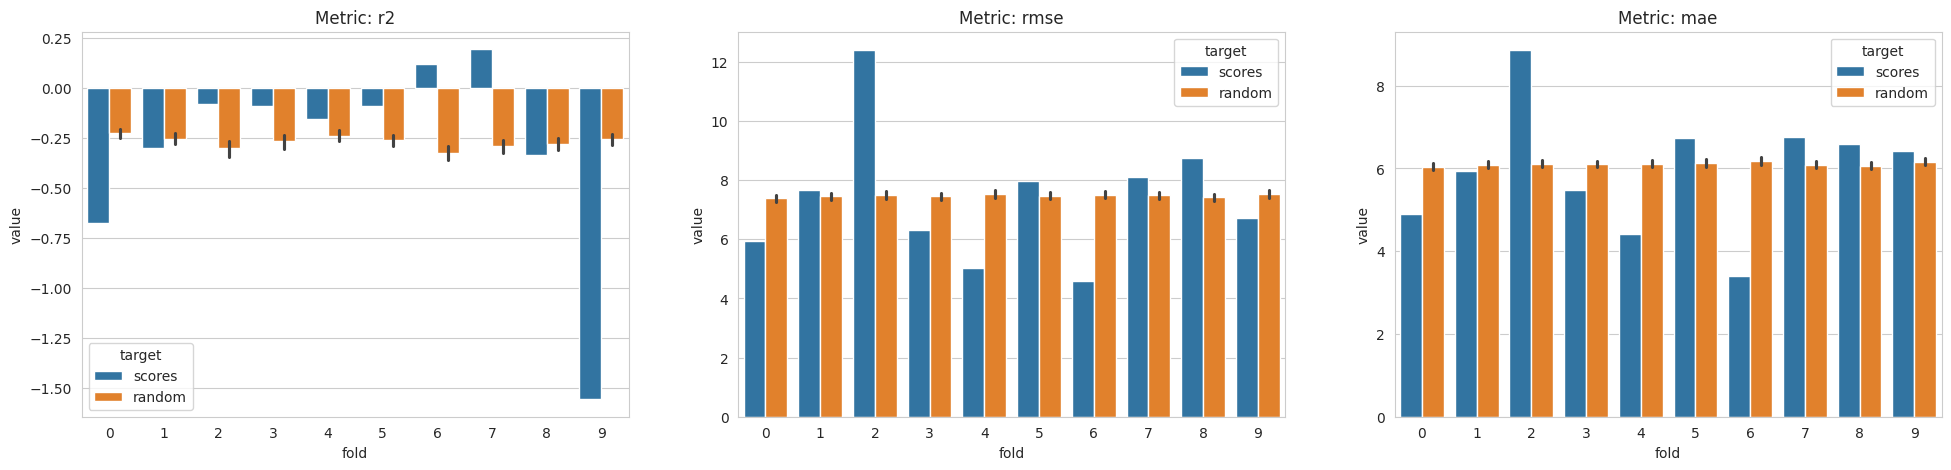

In [6]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(1, 3, figsize=(8*3, 5*1))
    
    for i, metric in enumerate(["r2", "rmse", "mae"]):
        sns.barplot(data=df_test[(df_test["metric"] == metric) & (df_test["split"] == "test")], x="fold", y="value", hue="target", ax=ax[i])
        ax[i].set_title(f"Metric: {metric}")

    plt.show()

# Prediction results with new stratification

In [3]:
# Loading data
saving_dir = "/neurospin/psy_sbox/analyses/2023_pauriau_EarlyBrainMarkersWithContrastiveAnalysis/models/vbm/20240927_nss_sex_age_stratification"
scheme = pd.read_csv("/neurospin/psy_sbox/analyses/2023_pauriau_EarlyBrainMarkersWithContrastiveAnalysis/data/processed/nss_sex_age_stratified_10_fold_ausz.csv", sep=",")
df = pd.read_csv("/neurospin/psy_sbox/analyses/2023_pauriau_EarlyBrainMarkersWithContrastiveAnalysis/data/processed/ausz_t1mri_participants.csv", sep=",")
preproc = "vbm"
nb_folds = 10

## NSS predictions

In [37]:
label = "NSS"
results = pd.read_csv(os.path.join(saving_dir, f"preproc-{preproc}_model-lrl2_label-{label}.csv"), sep=",")
results.loc[results["split"] == "test", ["metric", "value"]].groupby("metric").describe()

value                                                              \
       count      mean       std       min       25%       50%       75%   
metric                                                                     
mae     10.0  6.011419  1.661475  3.974185  4.786958  5.711735  7.377756   
r2      10.0 -0.165357  0.198825 -0.592166 -0.247124 -0.158695  0.002417   
rmse    10.0  7.468680  2.406035  4.871037  5.568586  7.101422  8.999369   

                   
              max  
metric             
mae      8.510181  
r2       0.047507  
rmse    12.445717

In [39]:
df_pred = df[["participant_id", "age", "sex", "diagnosis", "NSS"]].copy(deep=True)
for fold in range(nb_folds):
    df_pred.loc[scheme[f"fold{fold}"] == "test", "y_pred"] = np.load(os.path.join(saving_dir, f"y_pred_label-{label}_preproc-vbm_fold-{fold}.npy"))

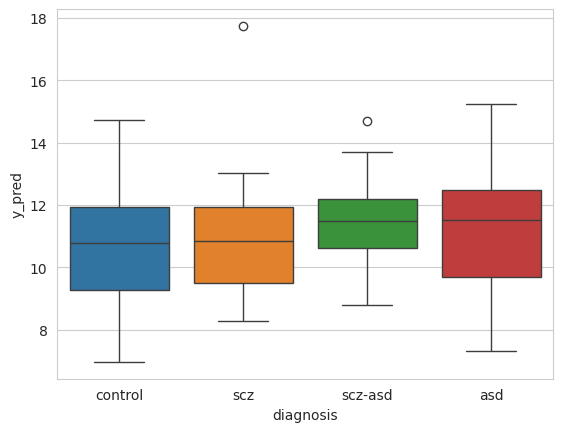

In [40]:
with sns.axes_style("whitegrid"):
    sns.boxplot(data=df_pred, x="diagnosis", y="y_pred", order=("control", "scz", "scz-asd", "asd"), hue="diagnosis", hue_order=("control", "scz", "scz-asd", "asd"))
plt.show()

In [41]:
data = defaultdict(list)
for diag in ("control", "scz", "scz-asd", "asd"):
    
    r2 = r2_score(y_pred=df_pred.loc[df_pred['diagnosis'] == diag, 'y_pred'],
                           y_true=df_pred.loc[df_pred['diagnosis'] == diag, 'NSS'])
    mae = mean_absolute_error(y_pred=df_pred.loc[df_pred['diagnosis'] == diag, 'y_pred'],
                                       y_true=df_pred.loc[df_pred['diagnosis'] == diag, 'NSS'])
    rmse = mean_squared_error(y_pred=df_pred.loc[df_pred['diagnosis'] == diag, 'y_pred'],
                                       y_true=df_pred.loc[df_pred['diagnosis'] == diag, 'NSS'],
                                       squared=False)
    print(f"# {diag}")
    print(f"R2:", r2)
    print(f"MAE:", mae)
    print(f"RMSE:", rmse)

    data["diagnosis"].append(diag)
    data["r2"].append(r2)
    data["mean_absolute_error"].append(mae)
    data["root_mean_squared_error"].append(rmse)
data_df = pd.DataFrame(data)

# control
R2: -2.8590595070946443
MAE: 5.9043869238633375
RMSE: 7.060722120094069
# scz
R2: -0.09900485996417085
MAE: 5.335592071215312
RMSE: 6.153695459238308
# scz-asd
R2: -0.0146374805374756
MAE: 5.382107210159302
RMSE: 8.371894681720947
# asd
R2: -1.0295534953841887
MAE: 6.825555381774902
RMSE: 8.728656151820992


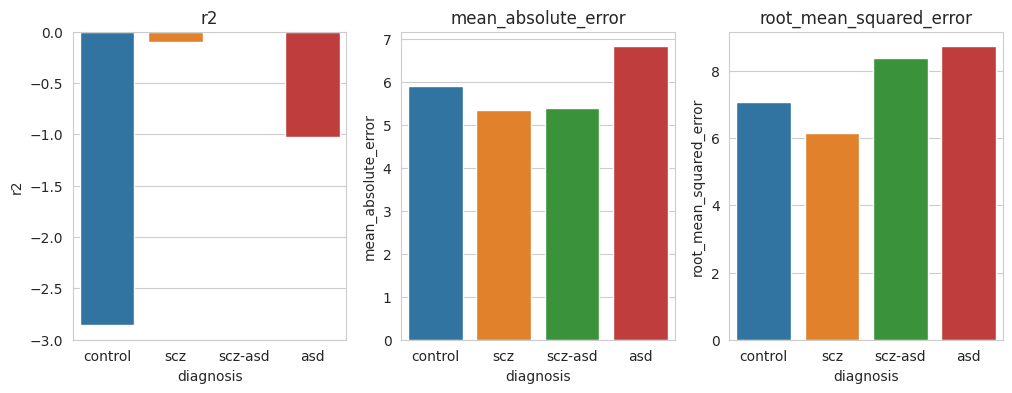

In [42]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(1, 3, figsize=(4*3, 4))
    for i, metric in enumerate(["r2", "mean_absolute_error", "root_mean_squared_error"]):
        sns.barplot(data=data_df, x="diagnosis", y=metric, order=("control", "scz", "scz-asd", "asd"), hue="diagnosis", hue_order=("control", "scz", "scz-asd", "asd"), ax=ax[i])
        ax[i].set_title(metric)
plt.show()

## Random permutation predictions

In [19]:
n_permutations = 1000
label = "NSS"
results = pd.concat([pd.read_csv(os.path.join(saving_dir, f"preproc-{preproc}_model-lrl2_label-{label}_permutation-{i}.csv")) for i in range(n_permutations+1)], axis=0)
results["target"] = results["label"].apply(lambda l: "random" if l != "NSS_permutation-0" else "scores")
results.head()

,label,fold,split,model,scaler,preproc,metric,value,target
0,NSS_permutation-0,0,train,lrl2,True,vbm,r2,1.000000,scores
1,NSS_permutation-0,0,train,lrl2,True,vbm,rmse,0.002333,scores
2,NSS_permutation-0,0,train,lrl2,True,vbm,mae,0.001771,scores
3,NSS_permutation-0,0,test,lrl2,True,vbm,r2,-0.229129,scores
4,NSS_permutation-0,0,test,lrl2,True,vbm,rmse,9.337629,scores


In [25]:
results.loc[results["label"] == "NSS_permutation-0", ["split", "metric", "value"]].groupby(["split", "metric"]).describe()

value                                                        \
             count      mean           std       min       25%       50%   
split metric                                                               
test  mae     10.0  6.011419  1.661475e+00  3.974185  4.786958  5.711735   
      r2      10.0 -0.165357  1.988247e-01 -0.592166 -0.247124 -0.158695   
      rmse    10.0  7.468680  2.406035e+00  4.871037  5.568586  7.101422   
train mae     10.0  0.001123  9.590860e-04  0.000003  0.000019  0.001769   
      r2      10.0  1.000000  5.294147e-08  1.000000  1.000000  1.000000   
      rmse    10.0  0.001437  1.227168e-03  0.000005  0.000025  0.002254   

                                   
                   75%        max  
split metric                       
test  mae     7.377756   8.510181  
      r2      0.002417   0.047507  
      rmse    8.999369  12.445717  
train mae     0.001887   0.001966  
      r2      1.000000   1.000000  
      rmse    0.002441   0.002489

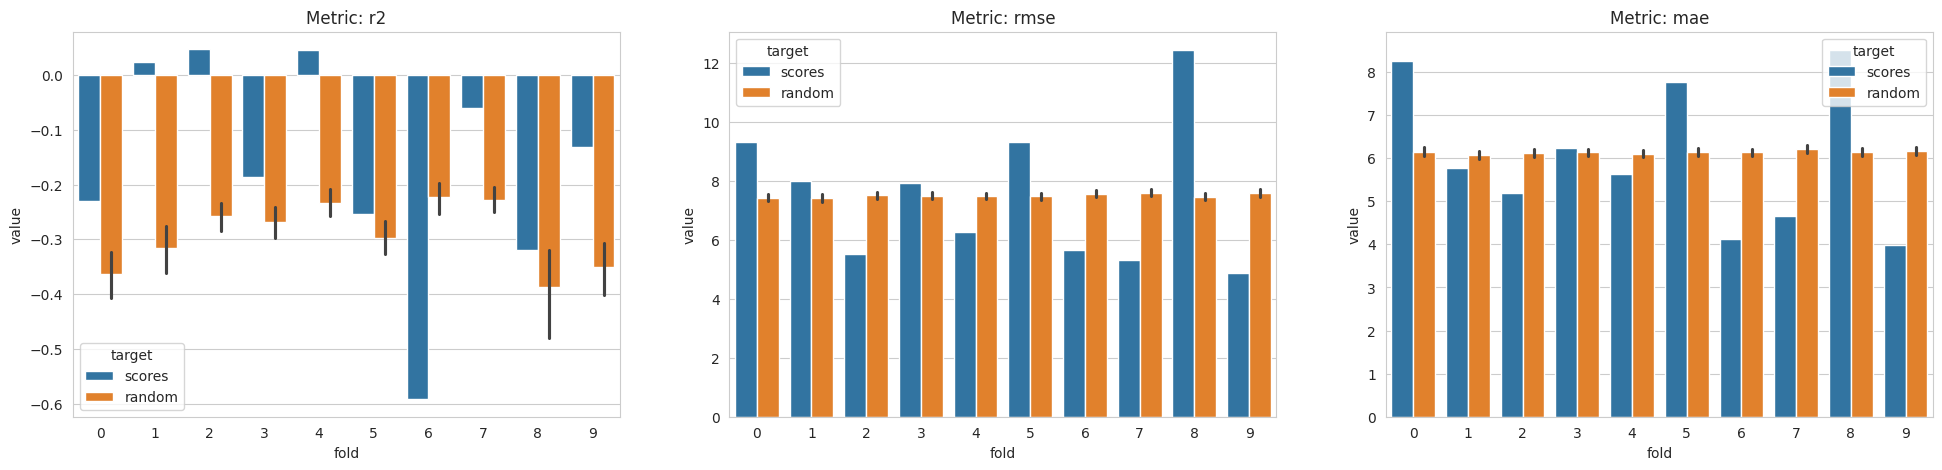

In [15]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(1, 3, figsize=(8*3, 5*1))
    
    for i, metric in enumerate(["r2", "rmse", "mae"]):
        sns.barplot(data=results[(results["metric"] == metric) & (results["split"] == "test")], x="fold", y="value", hue="target", ax=ax[i])
        ax[i].set_title(f"Metric: {metric}")

    plt.show()

## Metadata predictions

In [4]:
labels = ["NSS", "diagnosis", "sex", "age", "skeleton_size", "tiv"]
models = {l: "logreg" if l in ["diagnosis", "sex"] else "lrl2" for l in labels}
results = pd.concat([pd.read_csv(os.path.join(saving_dir, f"preproc-{preproc}_model-{models[l]}_label-{l}.csv")) for l in labels], axis=0)

In [6]:
results.loc[results["split"]=="test", ["label", "metric", "value"]].groupby(["label", "metric"]).describe([0.5])

value                                        \
                      count         mean         std          min   
label         metric                                                
NSS           mae      10.0     6.011419    1.661475     3.974185   
              r2       10.0    -0.165357    0.198825    -0.592166   
              rmse     10.0     7.468680    2.406035     4.871037   
age           mae      10.0     2.352856    0.590606     1.448048   
              r2       10.0     0.041880    0.298610    -0.564478   
              rmse     10.0     2.881711    0.673356     1.997694   
diagnosis     bacc     10.0     0.582024    0.165723     0.416667   
              roc_auc  10.0     0.726349    0.270387     0.250000   
sex           bacc     10.0     0.600000    0.210819     0.500000   
              roc_auc   8.0     0.889509    0.110246     0.666667   
skeleton_size mae      10.0  1435.218610  261.220655   998.392395   
              r2       10.0     0.057557    0.539539    -1.429051   
              rmse     10.0  1887.499951  420.007634  1120.949585   
tiv           mae      10.0    96.383549   17.021220    70.756866   
              r2       10.0     0.163937    0.595413    -1.500606   
              rmse     10.0   121.865656   19.512179    93.527473   

                                                 
                               50%          max  
label         metric                             
NSS           mae         5.711735     8.510181  
              r2         -0.158695     0.047507  
              rmse        7.101422    12.445717  
age           mae         2.169341     3.350899  
              r2          0.123363     0.353493  
              rmse        2.695568     4.052368  
diagnosis     bacc        0.500000     1.000000  
              roc_auc     0.767857     1.000000  
sex           bacc        0.500000     1.000000  
              roc_auc     0.913194     1.000000  
skeleton_size mae      1485.561279  1822.449707  
              r2          0.196385     0.417455  
              rmse     1857.580200  2450.367920  
tiv           mae        97.237469   134.647415  
              r2          0.299775     0.532360  
              rmse      122.271530   163.181351

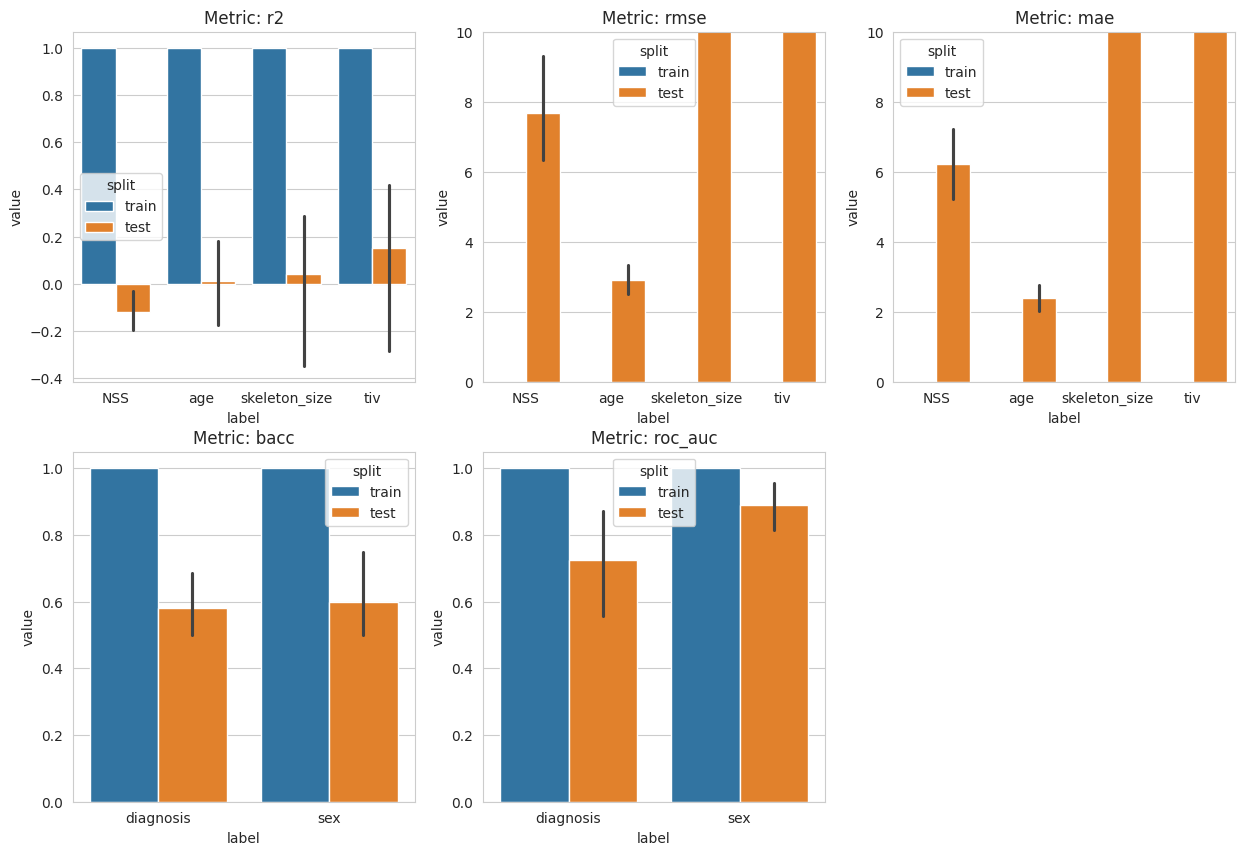

In [5]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(2, 3, figsize=(5*3, 5*2))
    
    for i, metric in enumerate(["r2", "rmse", "mae"]):
        sns.barplot(data=results[(results["metric"] == metric) & (results["fold"] != 6)], x="label", y="value", hue="split", ax=ax[0, i])
        ax[0, i].set_title(f"Metric: {metric}")
    ax[0, 1].set(ylim=(0, 10))
    ax[0, 2].set(ylim=(0, 10))

    for i, metric in enumerate(["bacc", "roc_auc"]):
        sns.barplot(data=results[(results["metric"] == metric)], x="label", y="value", hue="split", ax=ax[1, i])
        ax[1, i].set_title(f"Metric: {metric}")
    ax[1, 2].set_axis_off()

    plt.show()

# Stratification only on NSS scores

In [5]:
# Loading data
saving_dir = "/neurospin/psy_sbox/analyses/2023_pauriau_EarlyBrainMarkersWithContrastiveAnalysis/models/vbm/20241007_nss_stratification"
scheme = pd.read_csv("/neurospin/psy_sbox/analyses/2023_pauriau_EarlyBrainMarkersWithContrastiveAnalysis/data/without_nss_scores_from_tableau/processed/nss_stratified_10_fold_ausz.csv", sep=",")
df = pd.read_csv("/neurospin/psy_sbox/analyses/2023_pauriau_EarlyBrainMarkersWithContrastiveAnalysis/data/without_nss_scores_from_tableau/processed/ausz_t1mri_participants.csv", sep=",")
preproc = "vbm"
nb_folds = 10

## NSS predictions

In [6]:
label = "NSS"
results = pd.read_csv(os.path.join(saving_dir, f"preproc-{preproc}_model-lrl2_label-{label}.csv"), sep=",")
results.loc[results["split"] == "test", ["metric", "value"]].groupby("metric").describe()

value                                                              \
       count      mean       std       min       25%       50%       75%   
metric                                                                     
mae     10.0  5.863165  1.010283  4.417838  5.147860  5.865971  6.342456   
r2      10.0 -0.018861  0.133930 -0.281398 -0.043826  0.001170  0.089819   
rmse    10.0  7.440953  1.717422  5.877786  6.242110  6.953375  8.078292   

                   
              max  
metric             
mae      7.619876  
r2       0.119689  
rmse    11.526318

In [7]:
df_pred = df[["participant_id", "age", "sex", "diagnosis", "NSS"]].copy(deep=True)
for fold in range(nb_folds):
    df_pred.loc[scheme[f"fold{fold}"] == "test", "y_pred"] = np.load(os.path.join(saving_dir, f"y_pred_label-{label}_preproc-vbm_fold-{fold}.npy"))

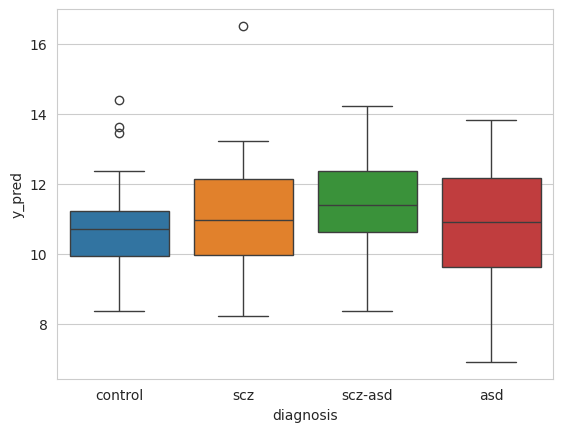

In [8]:
with sns.axes_style("whitegrid"):
    sns.boxplot(data=df_pred, x="diagnosis", y="y_pred", order=("control", "scz", "scz-asd", "asd"), hue="diagnosis", hue_order=("control", "scz", "scz-asd", "asd"))
plt.show()

In [9]:
data = defaultdict(list)
for diag in ("control", "scz", "scz-asd", "asd"):
    
    r2 = r2_score(y_pred=df_pred.loc[df_pred['diagnosis'] == diag, 'y_pred'],
                           y_true=df_pred.loc[df_pred['diagnosis'] == diag, 'NSS'])
    mae = mean_absolute_error(y_pred=df_pred.loc[df_pred['diagnosis'] == diag, 'y_pred'],
                                       y_true=df_pred.loc[df_pred['diagnosis'] == diag, 'NSS'])
    rmse = mean_squared_error(y_pred=df_pred.loc[df_pred['diagnosis'] == diag, 'y_pred'],
                                       y_true=df_pred.loc[df_pred['diagnosis'] == diag, 'NSS'],
                                       squared=False)
    print(f"# {diag}")
    print(f"R2:", r2)
    print(f"MAE:", mae)
    print(f"RMSE:", rmse)

    data["diagnosis"].append(diag)
    data["r2"].append(r2)
    data["mean_absolute_error"].append(mae)
    data["root_mean_squared_error"].append(rmse)
data_df = pd.DataFrame(data)

# control
R2: -2.806271111757932
MAE: 5.853853335747352
RMSE: 7.012263730895338
# scz
R2: -0.04252293539004781
MAE: 5.166223764419556
RMSE: 5.99347919656552
# scz-asd
R2: -0.017780470664565007
MAE: 5.409689807891846
RMSE: 8.384851248670515
# asd
R2: -1.0213129820559175
MAE: 6.827922477722168
RMSE: 8.710917824568151


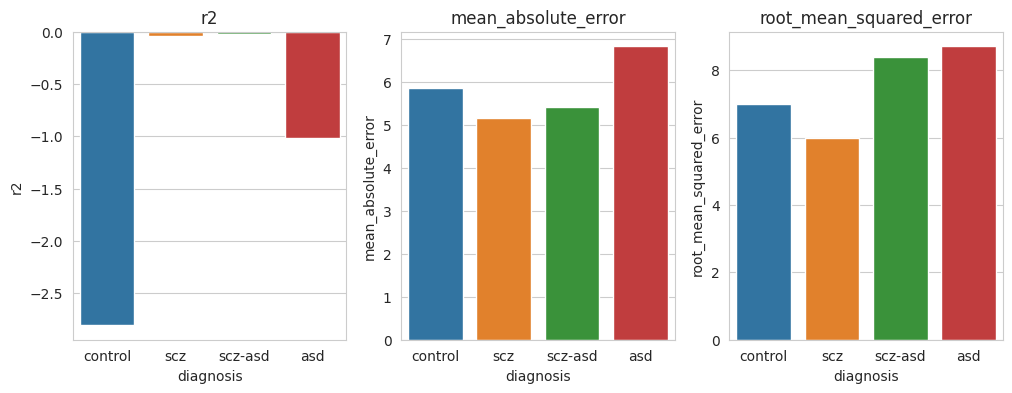

In [10]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(1, 3, figsize=(4*3, 4))
    for i, metric in enumerate(["r2", "mean_absolute_error", "root_mean_squared_error"]):
        sns.barplot(data=data_df, x="diagnosis", y=metric, order=("control", "scz", "scz-asd", "asd"), hue="diagnosis", hue_order=("control", "scz", "scz-asd", "asd"), ax=ax[i])
        ax[i].set_title(metric)
plt.show()

## Random permutation predictions

In [11]:
n_permutations = 1000
label = "NSS"
results = pd.concat([pd.read_csv(os.path.join(saving_dir, f"preproc-{preproc}_model-lrl2_label-{label}_permutation-{i}.csv")) for i in range(n_permutations+1)], axis=0)
results["target"] = results["label"].apply(lambda l: "random" if l != "NSS_permutation-0" else "scores")
results.head()

,label,fold,split,model,scaler,preproc,metric,value,target
0,NSS_permutation-0,0,train,lrl2,True,vbm,r2,1.000000,scores
1,NSS_permutation-0,0,train,lrl2,True,vbm,rmse,0.002381,scores
2,NSS_permutation-0,0,train,lrl2,True,vbm,mae,0.001845,scores
3,NSS_permutation-0,0,test,lrl2,True,vbm,r2,-0.204154,scores
4,NSS_permutation-0,0,test,lrl2,True,vbm,rmse,7.215789,scores


In [12]:
results.loc[results["label"] == "NSS_permutation-0", ["split", "metric", "value"]].groupby(["split", "metric"]).describe()

value                                                        \
             count      mean           std       min       25%       50%   
split metric                                                               
test  mae     10.0  5.863165  1.010283e+00  4.417838  5.147860  5.865971   
      r2      10.0 -0.018861  1.339304e-01 -0.281398 -0.043826  0.001170   
      rmse    10.0  7.440953  1.717422e+00  5.877786  6.242110  6.953375   
train mae     10.0  0.001679  5.898604e-04  0.000003  0.001839  0.001857   
      r2      10.0  1.000000  3.241934e-08  1.000000  1.000000  1.000000   
      rmse    10.0  0.002153  7.591015e-04  0.000005  0.002372  0.002399   

                                   
                   75%        max  
split metric                       
test  mae     6.342456   7.619876  
      r2      0.089819   0.119689  
      rmse    8.078292  11.526318  
train mae     0.001891   0.001916  
      r2      1.000000   1.000000  
      rmse    0.002441   0.002474

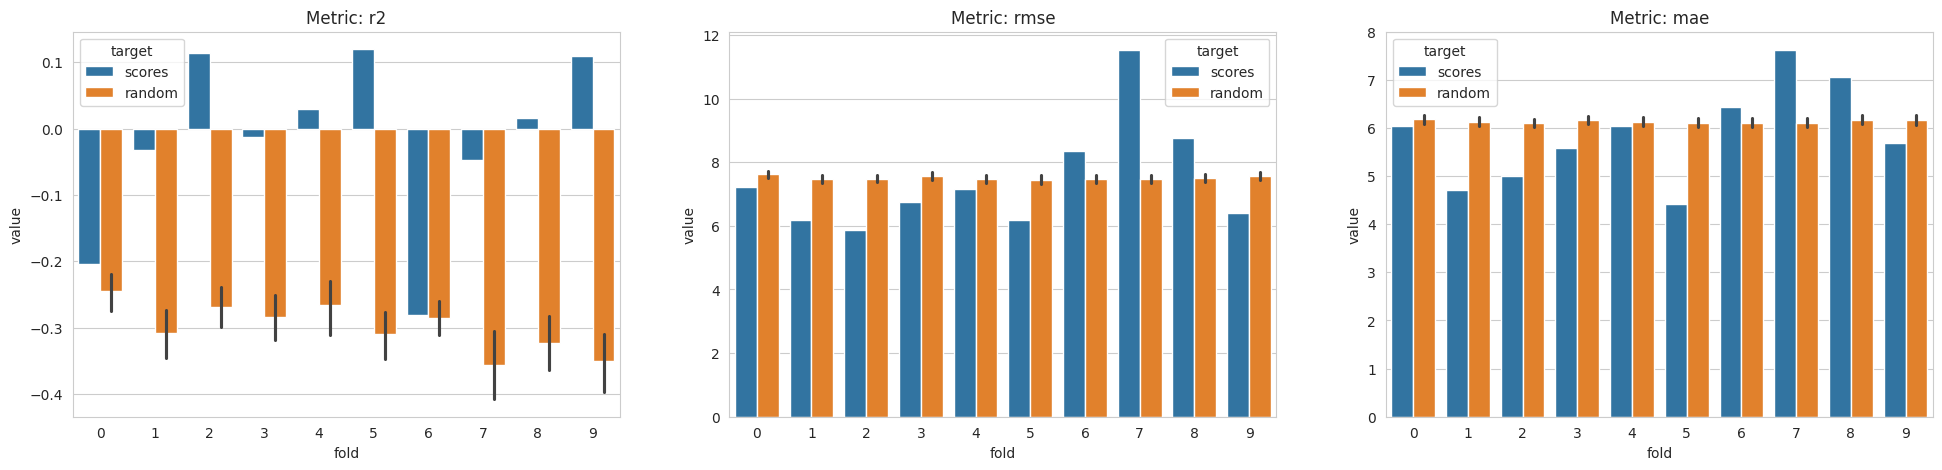

In [13]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(1, 3, figsize=(8*3, 5*1))
    
    for i, metric in enumerate(["r2", "rmse", "mae"]):
        sns.barplot(data=results[(results["metric"] == metric) & (results["split"] == "test")], x="fold", y="value", hue="target", ax=ax[i])
        ax[i].set_title(f"Metric: {metric}")

    plt.show()

## Metadata predictions

In [14]:
labels = ["NSS", "diagnosis", "sex", "age", "skeleton_size", "tiv"]
models = {l: "logreg" if l in ["diagnosis", "sex"] else "lrl2" for l in labels}
results = pd.concat([pd.read_csv(os.path.join(saving_dir, f"preproc-{preproc}_model-{models[l]}_label-{l}.csv")) for l in labels], axis=0)

In [ ]:
results.loc[results["split"]=="test", ["label", "metric", "value"]].groupby(["label", "metric"]).describe([0.5])

value                                                    \
                      count         mean         std         min          50%   
label         metric                                                            
NSS           mae      10.0     5.740329    0.915873    4.949099     5.677261   
              r2       10.0     0.057677    0.098674   -0.126055     0.062263   
              rmse     10.0     7.137735    1.526914    5.854827     6.607548   
age           mae      10.0     2.836034    0.705865    2.023410     2.640674   
              r2       10.0    -0.457079    0.486854   -1.314136    -0.225177   
              rmse     10.0     3.324520    0.781305    2.383820     3.067329   
diagnosis     bacc     10.0     0.478571    0.048211    0.357143     0.500000   
              roc_auc  10.0     0.538095    0.228918    0.222222     0.511905   
sex           bacc     10.0     0.550000    0.158114    0.500000     0.500000   
              roc_auc   9.0     0.619048    0.293166    0.238095     0.750000   
skeleton_size mae      10.0  1344.842950  445.743046  781.158997  1313.674438   
              r2       10.0     0.364591    0.098099    0.223268     0.361314   
              rmse     10.0  1633.595270  546.283267  971.874329  1640.301392   
tiv           mae      10.0   116.197135   30.729332   58.210396   118.914555   
              r2       10.0     0.018442    0.120469   -0.158569    -0.009145   
              rmse     10.0   144.824083   26.867321   93.988060   152.449242   

                                    
                               max  
label         metric                
NSS           mae         7.943972  
              r2          0.200263  
              rmse       11.078812  
age           mae         4.399748  
              r2          0.059686  
              rmse        4.962633  
diagnosis     bacc        0.500000  
              roc_auc     0.944444  
sex           bacc        1.000000  
              roc_auc     1.000000  
skeleton_size mae      2066.743408  
              r2          0.530791  
              rmse     2534.460693  
tiv           mae       157.182983  
              r2          0.254857  
              rmse      184.559143

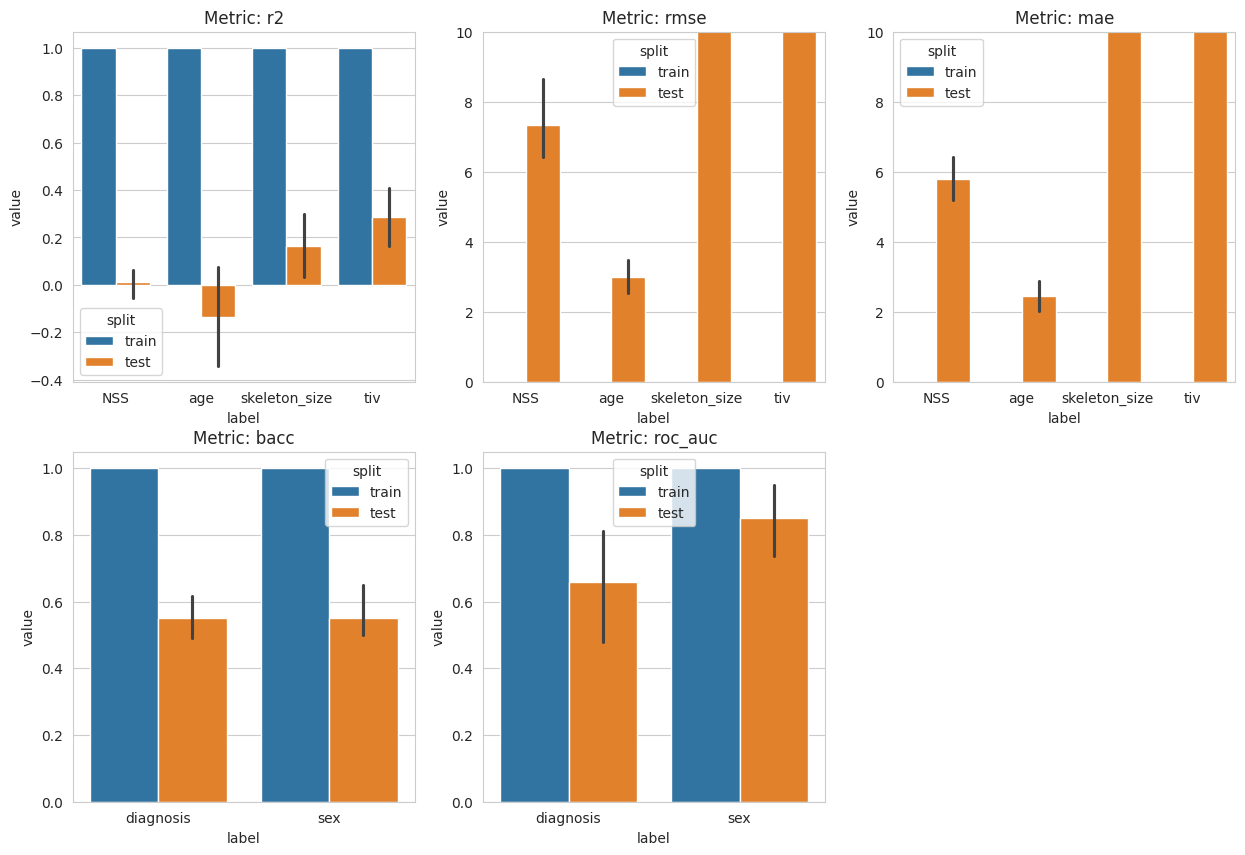

In [15]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(2, 3, figsize=(5*3, 5*2))
    
    for i, metric in enumerate(["r2", "rmse", "mae"]):
        sns.barplot(data=results[(results["metric"] == metric) & (results["fold"] != 6)], x="label", y="value", hue="split", ax=ax[0, i])
        ax[0, i].set_title(f"Metric: {metric}")
    ax[0, 1].set(ylim=(0, 10))
    ax[0, 2].set(ylim=(0, 10))

    for i, metric in enumerate(["bacc", "roc_auc"]):
        sns.barplot(data=results[(results["metric"] == metric)], x="label", y="value", hue="split", ax=ax[1, i])
        ax[1, i].set_title(f"Metric: {metric}")
    ax[1, 2].set_axis_off()

    plt.show()